# CUNEF MUCD 2021/2022  
## Machine Learning
## Análisis de Siniestralidad de Automóviles

### Autores:
- Andrés Mahía Morado
- Antonio Tello Gómez


# Regresión logística

La regresión logística es el tipo de regresión por excelencia para tareas de clasificación. Se enmarca en el conjunto de Modelos Lineales Generalizados (GLM) y usa como función de enlace la función logit.  

$\operatorname{logit}\left(p_{i}\right)=\ln \left(\frac{p_{i}}{1-p_{i}}\right)=\beta_{0}+\beta_{1} x_{1, i}+\cdots+\beta_{k} x_{k, i}$

![logistic](https://miro.medium.com/max/1280/1*CYAn9ACXrWX3IneHSoMVOQ.gif)

# Regularización

La regularización trata de penalizar la complejidad del modelo para evitar el overfitting, para ello se añade un término de penalización en la función de coste que tiende a reducir el tamaño de los coeficientes.  

La regularización Ridge o L2 añade la magnitud de los coeficientes al cuadrado como termino de penalización en la función de coste:   

$\sum_{i=1}^{n}\left(y_{i}-\sum_{j=1}^{p} x_{i j} \beta_{j}\right)^{2}+\lambda \sum_{j=1}^{p} \beta_{j}^{2}$  

La regularización Lasso o L1 añade la magnitud de los coeficientes en valor absoluto como termino de penalización en la función de coste: 

$\sum_{i=1}^{n}\left(Y_{i}-\sum_{j=1}^{p} X_{i j} \beta_{j}\right)^{2}+\lambda \sum_{j=1}^{p}\left|\beta_{j}\right|$  

El parámetro $\lambda\geq 0$ controla el tamaño de la penalización


In [1]:
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve

from sklearn.metrics import accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix


from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.linear_model import LogisticRegressionCV 
from sklearn.feature_selection import SelectFromModel

import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
from aux_func import evaluate_model
from aux_func import cargar_modelo

In [3]:
xtrain = pd.read_parquet("../data/xtrain.parquet")
ytrain = pd.read_parquet("../data/ytrain.parquet")['fatality']
xtest = pd.read_parquet("../data/xtest.parquet")
ytest = pd.read_parquet("../data/ytest.parquet")['fatality']

# Selección de Variables

Anteriormente expusimos porque descartamos aplicar la selección de variables al conjunto de datos. En este apartado, vamos a utilizar la regularización Lasso para seleccionar variables que luego emplearemos en nuestros modelos de regresión. Esto es redundante en cierto modo puesto que ya hemos incluido penalización en las regresiones. Sin embargo, hemos decidido incluirlo porque en el peor de los casos los resultados seran iguales a los que obtendríamos sin hacer este paso.  

### Regularización Lasso

In [4]:
sel_lasso = SelectFromModel(LogisticRegression(C=1, penalty='l1', 
                                          solver='liblinear'), threshold = 0.1) 
sel_lasso.fit(xtrain, ytrain)

SelectFromModel(estimator=LogisticRegression(C=1, penalty='l1',
                                             solver='liblinear'),
                threshold=0.1)

In [5]:
selected_feat = xtrain.columns[sel_lasso.get_support()]
selected_feat

Index(['quarter_1', 'quarter_2', 'quarter_3', 'quarter_4', 'weekday_1',
       'weekday_2', 'weekday_3', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'crash_type', 'crash_place', 'crash_weather',
       'surface_state', 'road_slope', 'traffic_state', 'vehicle_type',
       'passenger_sex_0.0', 'passenger_sex_1.0', 'passenger_safety',
       'passenger_type'],
      dtype='object')

In [21]:
with open('../models/selected_feat.pickle', 'wb') as f:
    pickle.dump(selected_feat, f)

In [22]:
cargar_modelo('../models/selected_feat.pickle')

Index(['quarter_1', 'quarter_2', 'quarter_3', 'quarter_4', 'weekday_1',
       'weekday_2', 'weekday_3', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'crash_type', 'crash_place', 'crash_weather',
       'surface_state', 'road_slope', 'traffic_state', 'vehicle_type',
       'passenger_sex_0.0', 'passenger_sex_1.0', 'passenger_safety',
       'passenger_type'],
      dtype='object')

In [6]:
print('total features: {}'.format((xtrain.shape[1])))
print('selected features: {}'.format(len(selected_feat)))

total features: 28
selected features: 24


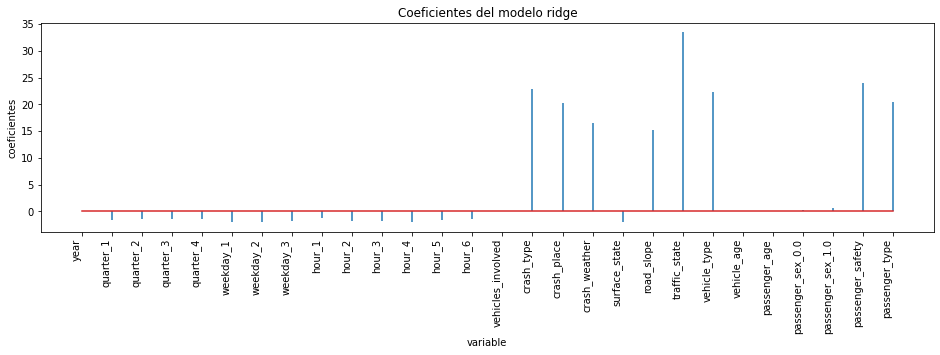

In [7]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': xtrain.columns,
                         'coef': sel_lasso.estimator_.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(16, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo ridge');

# Regresión Logística (Ridge)

In [9]:
%%time
clf = LogisticRegressionCV(cv=8, n_jobs=4, penalty='l2', random_state=0)
clf.fit(xtrain[selected_feat], ytrain)

Wall time: 13min 36s


LogisticRegressionCV(cv=8, n_jobs=4, random_state=0)

In [10]:
with open('../models/LR.pickle', 'wb') as f:
    pickle.dump(clf, f)

In [11]:
# Para no tener que ejecutar, saltarse el fit y ejecutar a partir de aquí
cargar_modelo('../models/LR.pickle')

In [12]:
ypred = clf.predict(xtest[selected_feat])
ypred_proba = clf.predict_proba(xtest[selected_feat])

In [13]:
evaluate_model(ytest,ypred, ypred_proba)

ROC-AUC score of the model: 0.8039610966391799
Accuracy of the model: 0.9847232961340163

Classification report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    997197
           1       0.42      0.00      0.00     15456

    accuracy                           0.98   1012653
   macro avg       0.70      0.50      0.50   1012653
weighted avg       0.98      0.98      0.98   1012653


Confusion matrix: 
[[997147     50]
 [ 15420     36]]



## Ajuste del umbral de predicción

In [14]:
# keep probabilities for the positive outcome only
yhat = ypred_proba[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)
evaluate_model(ytest,ypred_new_threshold,ypred_proba)

Best Threshold=0.013524, G-Mean=0.731
ROC-AUC score of the model: 0.8039610966391799
Accuracy of the model: 0.7528343865075203

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.75      0.86    997197
           1       0.04      0.71      0.08     15456

    accuracy                           0.75   1012653
   macro avg       0.52      0.73      0.47   1012653
weighted avg       0.98      0.75      0.85   1012653


Confusion matrix: 
[[751408 245789]
 [  4504  10952]]



# Regresión Logística (Lasso)

In [15]:
%%time
clf = LogisticRegression(random_state=0, n_jobs=4, penalty='l1', solver='liblinear')
clf.fit(xtrain[selected_feat], ytrain)

Wall time: 1min 42s


LogisticRegression(n_jobs=4, penalty='l1', random_state=0, solver='liblinear')

In [16]:
with open('../models/LRlasso.pickle', 'wb') as f:
    pickle.dump(clf, f)

In [17]:
cargar_modelo('../models/LRlasso.pickle')

In [18]:
ypred = clf.predict(xtest[selected_feat])
ypred_proba = clf.predict_proba(xtest[selected_feat])

In [19]:
evaluate_model(ytest, ypred, ypred_proba)

ROC-AUC score of the model: 0.8030306526185651
Accuracy of the model: 0.9847134210830364

Classification report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    997197
           1       0.42      0.00      0.01     15456

    accuracy                           0.98   1012653
   macro avg       0.70      0.50      0.50   1012653
weighted avg       0.98      0.98      0.98   1012653


Confusion matrix: 
[[997106     91]
 [ 15389     67]]



## Ajuste del umbral de predicción

In [20]:
# keep probabilities for the positive outcome only
yhat = ypred_proba[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)
evaluate_model(ytest,ypred_new_threshold,ypred_proba)

Best Threshold=0.012794, G-Mean=0.731
ROC-AUC score of the model: 0.8030306526185651
Accuracy of the model: 0.7440455911353643

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.74      0.85    997197
           1       0.04      0.72      0.08     15456

    accuracy                           0.74   1012653
   macro avg       0.52      0.73      0.47   1012653
weighted avg       0.98      0.74      0.84   1012653


Confusion matrix: 
[[742355 254842]
 [  4351  11105]]

